# Exercise 0-1 : Monte Calro simulation of the 2d Ising model (dynamics and snapshot)
2020, July, Tsuyoshi Okubo  
2021, July, Tsuyoshi Okubo  
2023, March, Tsuyoshi Okubo

This code simulates 2d Ising model on the square lattice, whose Hamiltonian is given by
$$ \mathcal{H} = -J \sum_{\langle i,j\rangle} S_i S_j - h \sum_i S_i ,$$
where $S_i = \pm 1$.

You can select three simulation algorithms:
* metropolis
* heatbath
* cluster (Swendsen-Wang)

The main outputs are:
* Energy: $\langle E\rangle = \langle \mathcal{H}\rangle/N$.
* Squared magnetization: $\langle M^2\rangle = \langle (\sum_i S_i)^2\rangle/N^2$.
* Specific heat: $N(\langle E^2\rangle - \langle E\rangle^2)/T$
* Magnetic susceptibility: $N(\langle M^2\rangle)/T$ 
* Connected susceptibility: $N(\langle M^2\rangle - \langle |M|\rangle^2)/T$ 
* Binder ratio: $(\langle M^4\rangle/\langle M^2\rangle^2)/T$


The code will make graphs of 
* Dynamics of physical quantities
* snapshot at the final MC step

By varying, system size $L$, the temperature $T$, the external magnetic field $h$, and the algorithm, let's see how the dynamics or erros in the expectations values change.

#### Parameters for MC simulations
* themalizatoin: MC steps for thermalization, which is not used for calculating expectation values.
* observation: MC steps for observation, which is used for calculating expectation values.
* random_seed: Seed for random numbser generator. For the same random_seed, you always obtain the same result.

#### Important notice
* This code works on python3 with numpy and numba modules.

In [1]:
import numpy as np
try:
    from Ising_lib import *
except ImportError:
    !wget https://raw.githubusercontent.com/TsuyoshiOkubo/Introduction-to-Tensor-Network/main/Exercise/Ising_lib.py
    from Ising_lib import *

%matplotlib inline
from matplotlib import pyplot


In [2]:
#Parameters for calculation
Tc = 2.0/np.log(1.0+np.sqrt(2.0)) ## The critical temperature of the Ising model

### input parameters ###
L=32
T=2.0*Tc ## T means T/J
h = 0

algorithm="metropolis"
#algorithm="heatbath"
#algorithm = "cluster"

random_seed = None # 11
thermalization = 10000
observation = 50000

######################


N=L*L


In [3]:
%%time
## Initialization and run simulation
mag, mag2, mag2_imp, mag4, mag_abs, ene,ene2,S_out = MC(L,T,h,thermalization,observation,random_seed,algorithm,output_snapshots=True)

CPU times: user 2.03 s, sys: 55.2 ms, total: 2.08 s
Wall time: 2.51 s


In [4]:
## Output with error estimated by Jackknife method
def variance(e,e2):
    return e2 -e**2
def binder(m2,m4):
    return m4 / m2 **2

E, E_err = Jackknife(ene,bin_size=max(100,observation//100))
E2,E2_err = Jackknife(ene2,bin_size=max(100,observation//100))
M,M_err = Jackknife(mag,bin_size=max(100,observation//100))
M2,M2_err = Jackknife(mag2,bin_size=max(100,observation//100))
M4,M4_err = Jackknife(mag4,bin_size=max(100,observation//100))
C, C_err = Jackknife(ene,bin_size=max(100,observation//100),func=variance, data2=ene2)
C *= N/T**2
C_err *= N/T**2
b, b_err = Jackknife(mag2,bin_size=max(100,observation//100),func=binder, data2=mag4)
chi, chi_err = Jackknife(mag_abs,bin_size=max(100,observation//100),func=variance, data2=mag2)


print ("[Outputs with errors estimated by Jackknife method]")
print ("T = " + repr(T))
print ("Energy = " + repr(E) + " +- " +repr(E_err))
print ("Energy^2 = " + repr(E2) + " +- " +repr(E2_err))
print ("Magnetization = " + repr(M) + " +- " +repr(M_err))
print ("Magnetization^2 = " + repr(M2) + " +- " +repr(M2_err))
print ("Magnetization^4 = " + repr(M4) + " +- " +repr(M4_err))
print ("Specific heat = " + repr(C) + " +- " +repr(C_err))
print ("Susceptibility = " + repr(M2/T * N) + " +- " +repr(M2_err/T * N))
print ("Connected Susceptibility = " + repr(chi/T * N) + " +- " +repr(chi_err/T * N))
print ("Binder ratio = " + repr(b) + " +- " +repr(b_err))

if algorithm == "cluster":
    M2_imp, M2_imp_err = Jackknife(mag2_imp,bin_size=max(100,observation//100))
    print ("Magnetization^2: improved estimator = " + repr(M2_imp) + " +- " +repr(M2_imp_err))
    print ("Susceptibility: improved estimator  = " + repr(M2_imp/T * N) + " +- " +repr(M2_imp_err/T * N))

[Outputs with errors estimated by Jackknife method]
T = 4.538370628426044
Energy = -0.47908757812500014 +- 0.000371308604603589
Energy^2 = 0.23199298309326175 +- 0.00035919702148850283
Magnetization = 0.00014109375000000005 +- 0.00022007898683486045
Magnetization^2 = 0.0032622462463378897 +- 2.1952127239719675e-05
Magnetization^4 = 3.139773136295844e-05 +- 4.593696758146507e-07
Specific heat = 0.122703866163818 +- 0.0009519371457826899
Susceptibility = 0.7360659650242216 +- 0.004953094432763174
Connected Susceptibility = 0.26580589477724886 +- 0.002002815044739534
Binder ratio = 2.950289416333066 +- 0.02023352151303297


In the following, we will analyze dynamics of the physical quantities:
* Magnetization
* Squared Magnetization
    * In the case of cluster algorithm, we also plot Squared Magnetization obtaind by the improved estimator
* Energy

The dynamics of magnetizations might be interesting. For low temperatures, the sign of magnetization hardly chages in the case of local updates (metropolis and heat bath). On the other hand, in the case of cluster update, the sign frequently changes even at a low temperature.

### Exercise
* Let's see what happens if you change $T$ as $T < T_c$ and $T > T_c$.
    * You may see depending on temperatures, MCMC dynamics can become slower.
    * Please see also errors of the observables.
* Let's see what happens when you change $L$.
    * You may see as $L$ is increased, dynamics of MCMC become slower especially around $T=T_c$.

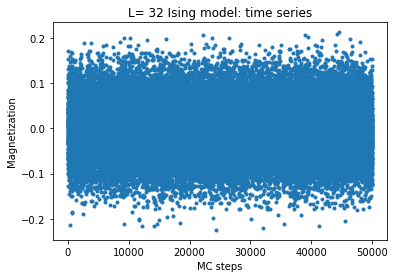

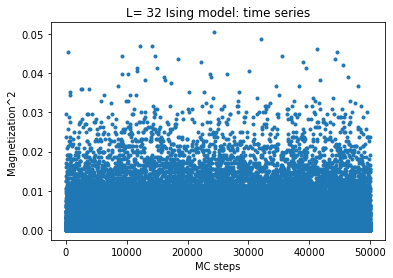

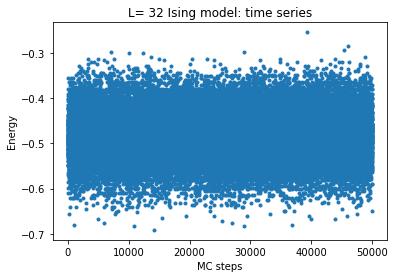

In [5]:
## plot time series

pyplot.figure()
pyplot.title("L= " + repr(L)+" Ising model:"+ " time series")
pyplot.xlabel("MC steps")
pyplot.ylabel("Magnetization")
pyplot.plot(np.arange(mag.size),mag,".")

pyplot.figure()
pyplot.title("L= " + repr(L)+" Ising model:"+ " time series")
pyplot.xlabel("MC steps")
pyplot.ylabel("Magnetization^2")
pyplot.plot(np.arange(mag2.size),mag2,".")

if algorithm == "cluster":
    pyplot.figure()
    pyplot.title("L= " + repr(L)+" Ising model:"+ " time series")
    pyplot.xlabel("MC steps")
    pyplot.ylabel("Magnetization^2:improved estimator")
    pyplot.plot(np.arange(mag2_imp.size),mag2_imp,".")



pyplot.figure()
pyplot.title("L= " + repr(L)+" Ising model:"+ " time series")
pyplot.xlabel("MC steps")
pyplot.ylabel("Energy")
pyplot.plot(np.arange(ene.size),ene,".")

pyplot.show()

In the following, we will plot snapshot obtained by MCMC simulation.
S_out

[[-1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1  1  1  1  1  1 -1 -1  1  1 -1  1 -1  1  1 -1  1  1  1  1]
 [-1  1 -1 -1 -1  1  1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1  1  1 -1 -1 -1  1  1  1 -1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1 -1  1 -1 -1  1  1  1 -1]
 [-1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1  1 -1  1  1 -1]
 [-1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1]
 [ 1 -1  1 -1 -1 -1  1  1  1  1  1 -1  1  1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1]
 [ 1  1 -1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1  1 -1  1]
 [-1  1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1  1 -1 -1  1  1  1 -1 -1  1  1 -1 -1  1]
 [ 1 -1 -1 -1  1  1 -1 -1  1 -1 -1  1 -1  1  1 -1 -1 -1  1  1 -1 -1 -1  1  1  1  1  1  1  1 -1  1]
 [-1 -1 -1

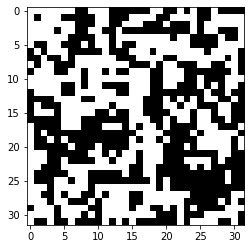

In [6]:
np.set_printoptions(threshold=1024)
np.set_printoptions(edgeitems=16)
np.set_printoptions(linewidth=110)
print(S_out)
pyplot.imshow(S_out,cmap="Greys")